## Decision Tree Regression

In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

## Read the dataset

In [3]:
import pandas as pd

In [4]:
df = pd.read_csv('50_Startups.csv')
df.head()

,RND,ADMIN,MKT,STATE,PROFIT
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RND     50 non-null     float64
 1   ADMIN   50 non-null     float64
 2   MKT     50 non-null     float64
 3   STATE   50 non-null     object 
 4   PROFIT  50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


In [6]:
df.isna().sum()

RND       0
ADMIN     0
MKT       0
STATE     0
PROFIT    0
dtype: int64

In [8]:
df.duplicated().sum()

0

## Seperate X and Y(Profit)

In [9]:
X = df.drop(columns='PROFIT')
Y = df[['PROFIT']]

In [11]:
X.head()

,RND,ADMIN,MKT,STATE
0,165349.20,136897.80,471784.10,New York
1,162597.70,151377.59,443898.53,California
2,153441.51,101145.55,407934.54,Florida
3,144372.41,118671.85,383199.62,New York
4,142107.34,91391.77,366168.42,Florida


In [13]:
Y.head()

,PROFIT
0,192261.83
1,191792.06
2,191050.39
3,182901.99
4,166187.94


## Seperate cat and con features for X

In [14]:
cat = list(X.columns[X.dtypes=='object'])
con = list(X.columns[X.dtypes!='object'])

In [15]:
cat

['STATE']

In [16]:
con

['RND', 'ADMIN', 'MKT']

## Create a preprocess pipeline

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

In [18]:
num_pipe = Pipeline(steps=[('impute', SimpleImputer(strategy='mean')),
                           ('scaler', StandardScaler())])

cat_pipe = Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                           ('ohe', OneHotEncoder(handle_unknown='ignore'))])

pre = ColumnTransformer([('num', num_pipe, con),
                         ('cat', cat_pipe, cat)])

In [19]:
pre

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impute', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['RND', 'ADMIN', 'MKT']),
                                ('cat',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['STATE'])])

In [21]:
X_pre = pre.fit_transform(X)
X_pre[0:5]

array([[ 2.01641149,  0.56075291,  2.15394309,  0.        ,  0.        ,
         1.        ],
       [ 1.95586034,  1.08280658,  1.9236004 ,  1.        ,  0.        ,
         0.        ],
       [ 1.75436374, -0.72825703,  1.62652767,  0.        ,  1.        ,
         0.        ],
       [ 1.55478369, -0.09636463,  1.42221024,  0.        ,  0.        ,
         1.        ],
       [ 1.5049372 , -1.07991935,  1.28152771,  0.        ,  1.        ,
         0.        ]])

In [22]:
cols = pre.get_feature_names_out()
cols

array(['num__RND', 'num__ADMIN', 'num__MKT', 'cat__STATE_California',
       'cat__STATE_Florida', 'cat__STATE_New York'], dtype=object)

In [24]:
X_pre = pd.DataFrame(X_pre, columns=cols)
X_pre.head()

,num__RND,num__ADMIN,num__MKT,cat__STATE_California,cat__STATE_Florida,cat__STATE_New York
0,2.016411,0.560753,2.153943,0.0,0.0,1.0
1,1.955860,1.082807,1.923600,1.0,0.0,0.0
2,1.754364,-0.728257,1.626528,0.0,1.0,0.0
3,1.554784,-0.096365,1.422210,0.0,0.0,1.0
4,1.504937,-1.079919,1.281528,0.0,1.0,0.0


## apply train test split

In [25]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X_pre, Y, test_size=0.2, random_state=14)

In [26]:
xtrain.shape

(40, 6)

In [27]:
xtest.shape

(10, 6)

## decision tree model creation

In [28]:
from sklearn.tree import DecisionTreeRegressor
model =  DecisionTreeRegressor(max_depth=3, min_samples_leaf=2, min_samples_split=7, criterion='squared_error')
model.fit(xtrain, ytrain)

DecisionTreeRegressor(max_depth=3, min_samples_leaf=2, min_samples_split=7)

In [29]:
model.score(xtrain, ytrain)

0.9615847604350176

In [30]:
model.score(xtest, ytest)

0.905026052276306

## Hyperparameter tuning(GridSearchCV)

In [31]:
params = {'max_depth':[1, 2, 3, 4, 5, 6, 7, 8],
          'min_samples_split':[5, 6, 7, 8, 9, 10],
          'min_samples_leaf':[3, 4, 5, 6, 7, 8],
          'criterion':['squared_error', 'absolute_error']}

In [32]:
from sklearn.model_selection import GridSearchCV
dtr = DecisionTreeRegressor()
gscv = GridSearchCV(dtr, param_grid=params, cv=5, scoring='neg_mean_squared_error')
gscv.fit(xtrain, ytrain)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'criterion': ['squared_error', 'absolute_error'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
                         'min_samples_leaf': [3, 4, 5, 6, 7, 8],
                         'min_samples_split': [5, 6, 7, 8, 9, 10]},
             scoring='neg_mean_squared_error')

In [33]:
gscv.best_params_

{'criterion': 'absolute_error',
 'max_depth': 6,
 'min_samples_leaf': 3,
 'min_samples_split': 5}

In [34]:
gscv.best_score_

-300721330.42071927

In [35]:
gscv.best_estimator_

DecisionTreeRegressor(criterion='absolute_error', max_depth=6,
                      min_samples_leaf=3, min_samples_split=5)

In [36]:
best_dtr = gscv.best_estimator_
best_dtr

DecisionTreeRegressor(criterion='absolute_error', max_depth=6,
                      min_samples_leaf=3, min_samples_split=5)

In [37]:
best_dtr.score(xtrain, ytrain)

0.9606724704080891

In [38]:
best_dtr.score(xtest, ytest)

0.9427479461535874

In [44]:
ypred_tr = best_dtr.predict(xtrain)
ytred_ts = best_dtr.predict(xtest)

In [41]:
ypred_tr[0:5]

array([ 90708.19,  71498.49, 126992.93, 144259.4 ,  90708.19])

In [42]:
ytrain.head()

,PROFIT
36,90708.19
44,65200.33
17,125370.37
11,144259.40
39,81005.76


In [45]:
ypred_ts = best_dtr.predict(xtest)

In [46]:
ypred_ts[0:5]

array([ 42582.08, 126992.93, 126992.93,  97103.38,  90708.19])

In [47]:
ytest.head()

,PROFIT
47,42559.73
21,111313.02
14,132602.65
30,99937.59
37,89949.14


In [48]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def evaluate_model(x, y, model):
    # predict train and test results
    ypred = model.predict(x)
    # Evaluate the model
    mse = mean_squared_error(y, ypred)
    rmse = mse**(1/2)
    mae = mean_absolute_error(y, ypred)
    r2 = r2_score(y, ypred)
    # Print the results
    print(f'Mean Squared Error : {mse:.2f}')
    print(f'Root Mean Squared Error : {rmse:.2f}')
    print(f'Mean Absolute Error : {mae:.2f}')
    print(f'R2 Score : {r2:.4f}')

In [49]:
evaluate_model(xtrain, ytrain, best_dtr)

Mean Squared Error : 56709076.18
Root Mean Squared Error : 7530.54
Mean Absolute Error : 4534.61
R2 Score : 0.9607


In [50]:
evaluate_model(xtest, ytest, best_dtr)

Mean Squared Error : 118905861.59
Root Mean Squared Error : 10904.40
Mean Absolute Error : 8775.76
R2 Score : 0.9427


## Ploting the decision tree

In [52]:
best_dtr

DecisionTreeRegressor(criterion='absolute_error', max_depth=6,
                      min_samples_leaf=3, min_samples_split=5)

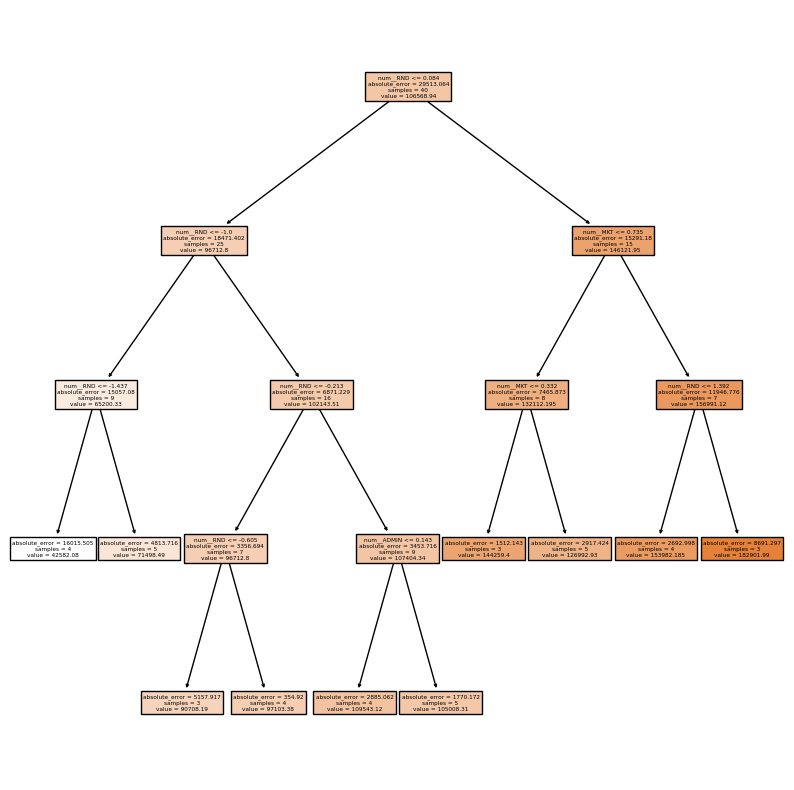

In [51]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
plt.figure(figsize=(10,10))
plot_tree(best_dtr, feature_names=xtrain.columns, filled=True)
plt.show()

## Plot features importants

In [53]:
imp = best_dtr.feature_importances_
imp

array([0.86257248, 0.01070156, 0.12672596, 0.        , 0.        ,
       0.        ])

In [54]:
imp = pd.Series(imp)
imp

0    0.862572
1    0.010702
2    0.126726
3    0.000000
4    0.000000
5    0.000000
dtype: float64

In [55]:
imp.index = xtrain.columns

In [56]:
imp

num__RND                 0.862572
num__ADMIN               0.010702
num__MKT                 0.126726
cat__STATE_California    0.000000
cat__STATE_Florida       0.000000
cat__STATE_New York      0.000000
dtype: float64

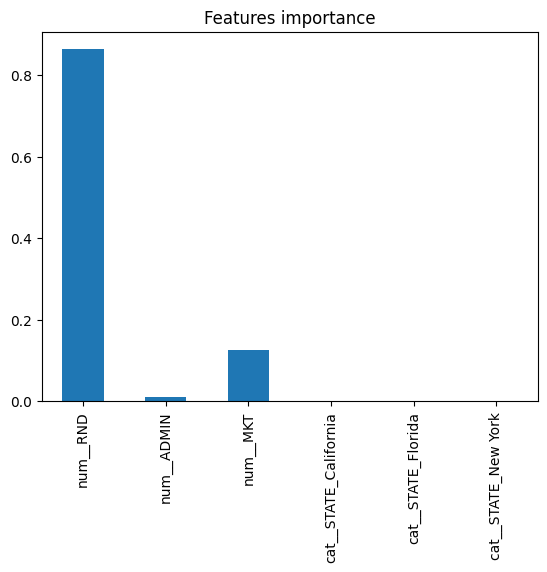

In [58]:
imp.plot(kind='bar', title='Features importance')
plt.show()

## Predicting out of sample data

In [61]:
xnew = pd.read_csv('test.csv')
xnew

,RND,ADMIN,MKT,STATE
0,78013.11,121597.55,264346.06,California
1,22177.74,154806.14,28334.72,California
2,23640.93,96189.63,148001.11,California
3,101913.08,110594.11,229160.95,Florida
4,77044.01,99281.34,140574.81,New York
5,542.05,51743.15,0.00,New York
6,61136.38,152701.92,88218.23,New York
7,100671.96,91790.61,249744.55,California
8,28663.76,127056.21,201126.82,Florida
9,20229.59,65947.93,185265.10,New York


In [62]:
xnew_pre = pre.transform(xnew)
xnew_pre

array([[ 0.0944412 ,  0.00911842,  0.44044622,  1.        ,  0.        ,
         0.        ],
       [-1.13430539,  1.20641936, -1.50907418,  1.        ,  0.        ,
         0.        ],
       [-1.10210556, -0.90693753, -0.52059596,  1.        ,  0.        ,
         0.        ],
       [ 0.62039825, -0.38759909,  0.14980727,  0.        ,  1.        ,
         0.        ],
       [ 0.0731146 , -0.79546917, -0.5819393 ,  0.        ,  0.        ,
         1.        ],
       [-1.61043334, -2.50940884, -1.74312698,  0.        ,  0.        ,
         1.        ],
       [-0.27695823,  1.13055391, -1.01441945,  0.        ,  0.        ,
         1.        ],
       [ 0.59308542, -1.0655396 ,  0.31983362,  1.        ,  0.        ,
         0.        ],
       [-0.99157015,  0.20592469, -0.08176257,  0.        ,  1.        ,
         0.        ],
       [-1.17717755, -1.99727037, -0.21278487,  0.        ,  0.        ,
         1.        ],
       [-1.60035036,  0.10125394, -1.72739998,  0.

## Estimate the profit of startups

In [64]:
pred = best_dtr.predict(xnew_pre)
pred

d:\VSCode GitHub\repository\venv\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


array([126992.93 ,  71498.49 ,  71498.49 , 144259.4  , 109543.12 ,
        42582.08 ,  97103.38 , 144259.4  ,  90708.19 ,  71498.49 ,
        42582.08 , 144259.4  ,  97103.38 , 153982.185,  90708.19 ])

## Save the result to xnew

In [65]:
xnew['PROFIT']= pred
xnew

,RND,ADMIN,MKT,STATE,PROFIT
0,78013.11,121597.55,264346.06,California,126992.930
1,22177.74,154806.14,28334.72,California,71498.490
2,23640.93,96189.63,148001.11,California,71498.490
3,101913.08,110594.11,229160.95,Florida,144259.400
4,77044.01,99281.34,140574.81,New York,109543.120
5,542.05,51743.15,0.00,New York,42582.080
6,61136.38,152701.92,88218.23,New York,97103.380
7,100671.96,91790.61,249744.55,California,144259.400
8,28663.76,127056.21,201126.82,Florida,90708.190
9,20229.59,65947.93,185265.10,New York,71498.490


## Save this result into CSV

In [66]:
xnew.to_csv('StartupResult.csv', index=False)